# BitTrack Project
## Send request and Get data

In [1]:
import requests
import csv
import json

import datetime
import time
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

# Time in UNIX format
month = 2629743
now = int(time.time())
start_time = now - 3*month
DATALENGTH = 500
ema_length = 50

url = f"http://api.coincap.io/v2/assets/bitcoin/history?interval=h1"
print(url)

# Request data from the API
response = requests.request("GET", url, headers={}, data={})
json_data = json.loads(response.text.encode('utf8'))
# print(json_data)
bitcoin_data = json_data["data"]

df = pd.DataFrame(bitcoin_data)
## Export data as a csv file
# df.to_csv('BTCUSD.csv', index=False)
print(df.sample)
# df.dtypes

# Filter only the columns we need
df = pd.DataFrame(bitcoin_data, columns=['time', 'priceUsd'])
# Get last 200 rows and REVERSE, newest price on top (index 0)
df = df[:-DATALENGTH-1:-1]
print(df.sample)

# Convert 'priceUsd' datatype to something numeric
df['priceUsd'] = pd.to_numeric(df['priceUsd'], errors='coerce', downcast='integer').fillna(0, downcast='infer')
df.dtypes
df.info()

http://api.coincap.io/v2/assets/bitcoin/history?interval=h1
<bound method NDFrame.sample of                    priceUsd           time          circulatingSupply  \
0    41651.2425947319829000  1627822800000  18773137.0000000000000000   
1    41497.9376707940375347  1627826400000  18773212.0000000000000000   
2    41376.9747561292609221  1627830000000  18773212.0000000000000000   
3    41305.6808877163402272  1627833600000  18773250.0000000000000000   
4    41248.8477154476087985  1627837200000  18773250.0000000000000000   
..                      ...            ...                        ...   
680  47717.3187033799997429  1630396800000  18802231.0000000000000000   
681  47760.9393325514000107  1630400400000  18802281.0000000000000000   
682  47437.6422609054622552  1630404000000  18802281.0000000000000000   
683  47431.8005471760013025  1630407600000  18802493.0000000000000000   
684  47917.5247017644472969  1630411200000  18802493.0000000000000000   

                         date  

In [2]:
# Check data 
prices = df['priceUsd']
print(prices)

684    47917.524702
683    47431.800547
682    47437.642261
681    47760.939333
680    47717.318703
           ...     
4      41248.847715
3      41305.680888
2      41376.974756
1      41497.937671
0      41651.242595
Name: priceUsd, Length: 685, dtype: float64


In [3]:
# Calculate and check last ema value 
count = 0
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

In [4]:
print("EMA50 H1:", ema(df['priceUsd'], count))

EMA50 H1: 47917.92208990034


In [5]:
# Process UNIX time to readable form
timeStamp =  df['time'].values.tolist()
timeStamp = [x / 1000 for x in timeStamp]

In [6]:
# Insert readable timeStamp column to 'df'
df['timeStamp'] = pd.to_datetime(timeStamp, unit='s')

In [7]:
# Check
df.sample

<bound method NDFrame.sample of               time      priceUsd           timeStamp
684  1630411200000  47917.524702 2021-08-31 12:00:00
683  1630407600000  47431.800547 2021-08-31 11:00:00
682  1630404000000  47437.642261 2021-08-31 10:00:00
681  1630400400000  47760.939333 2021-08-31 09:00:00
680  1630396800000  47717.318703 2021-08-31 08:00:00
..             ...           ...                 ...
4    1627837200000  41248.847715 2021-08-01 17:00:00
3    1627833600000  41305.680888 2021-08-01 16:00:00
2    1627830000000  41376.974756 2021-08-01 15:00:00
1    1627826400000  41497.937671 2021-08-01 14:00:00
0    1627822800000  41651.242595 2021-08-01 13:00:00

[685 rows x 3 columns]>

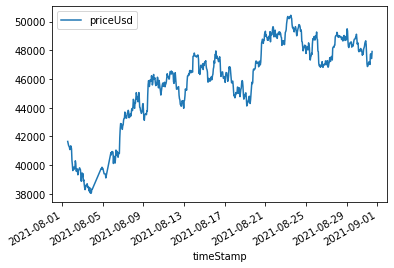

In [8]:
# Plot the data
df.plot(x ='timeStamp', y='priceUsd', kind = 'line')
plot.show()

## Calculate the possible EMA for each timeStamp
'possible' means timeStamp that have at lease 50 values before it. After that, we add EMA value along with the above figure.

In [9]:
short_df = df.head(DATALENGTH-ema_length)
short_df.reset_index()

,index,time,priceUsd,timeStamp
0,684,1630411200000,47917.524702,2021-08-31 12:00:00
1,683,1630407600000,47431.800547,2021-08-31 11:00:00
2,682,1630404000000,47437.642261,2021-08-31 10:00:00
3,681,1630400400000,47760.939333,2021-08-31 09:00:00
4,680,1630396800000,47717.318703,2021-08-31 08:00:00
...,...,...,...,...
665,19,1627891200000,40134.754873,2021-08-02 08:00:00
666,18,1627887600000,40301.141044,2021-08-02 07:00:00
667,17,1627884000000,39778.136764,2021-08-02 06:00:00
668,16,1627880400000,39723.659207,2021-08-02 05:00:00


In [10]:
short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))

C:\Users\Duy Anh\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [11]:
# short_df['N'] = np.arange(len(short_df))
short_df.insert(loc=0, column='N', value=np.arange(len(short_df)))

In [12]:
# Try modifying a value in EMA column
# short_df.loc[713,'EMA'] = 999999
# Try accessing short_df
print(short_df['EMA'].iloc[-1])

0.0


In [15]:
# Finalize 'ema' function to run in for loop
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

# Calculate ema values and replace them into the dataframe
for i in range(0, DATALENGTH-ema_length):
    count = 0
    # short_df.iloc[ ?,4 ] => 'EMA' column
    # df['priceUsd'].iloc[ i: ] => use dataFrame from newest to the last 51st row
    short_df.iloc[ i,4 ] = ema( df['priceUsd'].iloc[ i: ], count )


C:\Users\Duy Anh\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


IndexError: single positional indexer is out-of-bounds

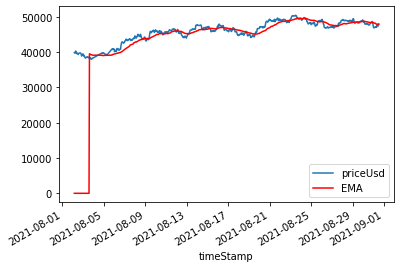

In [14]:
# Reference article https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
ax = plot.gca()
short_df.plot(kind='line',x='timeStamp',y='priceUsd', ax=ax)
short_df.plot(kind='line',x='timeStamp',y='EMA', color='red', ax=ax)
plot.show()

## Create a while loop to update price constantly

## Alarm when PRICE cross EMA

## Analyze profit/loss if trade base on EMA 

Strategy 1  
using data in the past 720 hours  
Long/Short when Price cross EMA50 in H1 timeframe, update each hour  
TP when +1000, move SL to entry  


Strategy 2  
using data in the past 720 hours  
with R:R=1:1, TP = SL = 5%  
TP 80% when reach target, move SL to entry


In [17]:
# check
df['timeStamp'].iloc[50]

Timestamp('2021-08-29 10:00:00')

In [18]:
balance = 1000
placed_order = 0
old_entry = 0

for i in reversed(range(0, DATALENGTH-ema_length-1)):
    count = 0
    old_price = df['priceUsd'].iloc[i+1]
    current_price = df['priceUsd'].iloc[i]
    timeStamp = df['timeStamp'].iloc[i]
    current_ema = ema( df['priceUsd'].iloc[i:], count )
    
    # TP if price moves 1000
    if (abs(current_price - old_entry) >= 1000):

        if (placed_order == 1):
            balance = balance * current_price / old_entry
            print(f'CLOSE BUY POSITION ' + '='*45 + \
              f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')

        elif (placed_order == -1):
            balance = balance * (2 - current_price / old_entry)
            print(f'CLOSE SELL POSITION ' + '='*45 + \
              f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')

        placed_order = 0

    # Price going up
    if (old_price <= current_ema <= current_price):
        # If placed SELL order, close that previous SELL order
        if (placed_order == -1):
            balance = balance * (2 - current_price / old_entry)
            print(f'CLOSE SELL POSITION ' + '='*45 + \
                f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')
            placed_order = 0
        # Place order if there's no position
        if (placed_order == 0):
            old_entry = current_price
            placed_order = 1
            print(f'BUY ' + '='*50 + \
                f'\nEntry: {old_entry}  \nBalance: {balance}\n')

    # Price going down
    elif (old_price >= current_ema >= current_price):
        # If placed BUY order, close that previous BUY order
        if (placed_order == 1):
            balance = balance * current_price / old_entry
            print(f'CLOSE BUY POSITION ' + '='*45 + \
                f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')
            placed_order = 0
        # Place order if there's no position
        if (placed_order == 0):
            old_entry = current_price
            placed_order = -1
            print(f'SELL ' + '='*50 + \
                f'\nEntry: {old_entry}  \nBalance: {balance}\n')

    print(f'i = {i}')
    print(f'timeStamp = {timeStamp}')
    print(f'price = {current_price}')
    print(f'ema = {current_ema}\n')


IndexError: single positional indexer is out-of-bounds

#### Errors:
- Sell 2 consecutive times  
- i = 441 different prices  
#### Todos:
- Add B/S on the chart where order is placed
- TP1 is 80% when price moves xxx, TP2 the rest 20% is when price crosses EMA50 
- Create a Account class